# Household Power Consumption — Minutely → Hourly/Daily (Live Walkthrough)

**Date:** 2025-10-25

This notebook demonstrates end‑to‑end **time series data processing** on the
_UCI Individual Household Electric Power Consumption_ dataset (France, 2006–2010).
We will:
- Load & parse minute‑level data
- Attach the correct timezone (**Europe/Paris**) and handle DST
- Reveal gaps vs. resample and aggregate into **hourly** and **daily** series
- Impute missing values for consistent series
- Build rolling/EWM smoothers and flag outliers
- Compute **daily energy (kWh)** from minute or hourly data
- Create quick calendar summaries (hour‑of‑day / day‑of‑week)

> Notes:
> - The dataset timestamps are in **local time (France)**, without timezone info (tz‑naive). We will **tz_localize('Europe/Paris')**.
> - Download dataset from: https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip (No need to unzip; we will read directly from the zip file.)


## 0) Setup


In [1]:
import zipfile

import pandas as pd
import matplotlib.pyplot as plt

# Simple plotting helpers (single-figure, default colors)
def plot_series(s, title=None, ylabel=None, rotation=None):
    fig = plt.figure()
    plt.plot(s.index, s.values)
    if title: plt.title(title)
    plt.xlabel("Time"); plt.ylabel(ylabel or (s.name or "value"))
    if rotation: plt.xticks(rotation=rotation)
    plt.tight_layout(); plt.show()

def plot_two_series(a, b, title=None, ylabel=None, legend=("A","B"), rotation=None):
    fig = plt.figure()
    plt.plot(a.index, a.values, label=legend[0])
    plt.plot(b.index, b.values, label=legend[1])
    if title: plt.title(title)
    plt.xlabel("Time"); plt.ylabel(ylabel or (a.name or "value"))
    if rotation: plt.xticks(rotation=rotation)
    plt.legend(); plt.tight_layout(); plt.show()

LOCAL_TZ = "Europe/Paris"

## 1) Load & parse the UCI dataset (minute‑level)

We stream the official ZIP from UCI, parse the semicolon‑delimited text, combine **Date+Time** into a timestamp, and set a `DateTimeIndex`.
- Missing values are marked by `?` in the file.
- We **sort** and **de‑duplicate** timestamps.


In [2]:
# Load local zip file
zip_path = "./datasets/individual+household+electric+power+consumption.zip"
with zipfile.ZipFile(zip_path) as z:
    # Main text file inside the zip
    with z.open("household_power_consumption.txt") as csv_file:
        # Parse with combined timestamp and day-first dates
        df = pd.read_csv(
            csv_file, sep=";", na_values="?", low_memory=False,
        )

# Parse timestamps
df["timestamp"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S",
    errors="coerce"
)

# Remove original Date and Time columns
del df["Date"]
del df["Time"]

# Index and sort by timestamp
df = df.set_index("timestamp").sort_index()

# Remove duplicate timestamps, keeping the last occurrence
df = df[~df.index.duplicated(keep="last")]

# Convert numeric columns
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(f"Number of rows: {len(df)}")
df.head()

Number of rows: 2075259


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
timestamp,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## 2) Timezone & Daylight-Saving Time (DST) handling

Timestamps are **local clock time in France**, but tz‑naive. We **attach** `Europe/Paris` with `tz_localize`.
- We set `ambiguous='NaT'` and `nonexistent='NaT'` to avoid incorrect clock times at DST transitions.
- You can later convert to another zone with `tz_convert(...)` if needed.


In [3]:
# Attach local timezone (no clock shift, just labeling)
df = df.tz_localize(LOCAL_TZ,
                    ambiguous="NaT",   # the repeated hour in October becomes NaT
                    nonexistent="NaT") # the skipped hour in March becomes NaT


# Inspect overall time span and sampling
print("Span:", df.index.min(), "→", df.index.max())
print("Rows:", len(df))

Span: 2006-12-16 17:24:00+01:00 → 2010-11-26 21:02:00+01:00
Rows: 2075259


In [4]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
timestamp,,,,,,,
2006-12-16 17:24:00+01:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00+01:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00+01:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00+01:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00+01:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## 3) Handling duplicates; Reveal minute‑level gaps vs. resampling

`asfreq('T')` reindexes to an exact minute grid and shows gaps as `NaN`.
This is useful before downsampling, so you can decide on imputation strategies.


In [5]:
# How many duplicate timestamps?
print(f"Duplicate timestamp rows: {df.index.duplicated(keep=False).sum()}")

Duplicate timestamp rows: 480


In [6]:
# Collapse exact-duplicate timestamps by averaging numeric columns
df = df.groupby(level=0).mean(numeric_only=True)
print(f"Duplicate timestamp rows: {df.index.duplicated(keep=False).sum()}")
print(f"Number of rows after collapsing duplicates: {len(df)}")

Duplicate timestamp rows: 0
Number of rows after collapsing duplicates: 2074779


In [7]:
# Reveal gaps explicitly (no aggregation)
# What does .asfreq("min") do? — It reindexes the DataFrame to have a row for every minute.
df_minute = df.asfreq("min")
print("Before asfreq — rows:", len(df))
print("After asfreq('min') — rows:", len(df_minute))

Before asfreq — rows: 2074779
After asfreq('min') — rows: 2075259


In [8]:
# Inspect NA values in other columns
display(df.isna().sum())
display(df_minute.isna().sum())

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Global_active_power      26459
Global_reactive_power    26459
Voltage                  26459
Global_intensity         26459
Sub_metering_1           26459
Sub_metering_2           26459
Sub_metering_3           26459
dtype: int64

## 4) Hourly aggregation & imputation

We compute **hourly means** for key variables, then impute small gaps with time interpolation + forward fill.
- `resample('H').mean()` performs aggregation **and** creates an hourly grid.
- After imputation, we can compute rolling stats safely.


Hourly active power: missing before imputation = 429, after = 0
Hourly voltage: missing before imputation = 429, after = 0


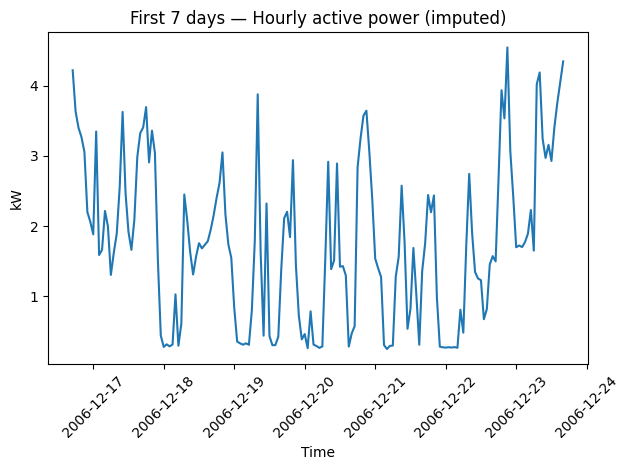

In [9]:
kw = df_minute["Global_active_power"]  # kW instantaneous (approx)
volt = df_minute["Voltage"]

# Hourly means
# What does this do?
# First resamples data into hourly bins, then computes the mean of each bin.
# If a bin has no data, the result is NaN for that hour.
hourly_kw = kw.resample("h").mean()
hourly_volt = volt.resample("h").mean()

# Impute small gaps
# First impute missing values by interpolation (`.interpolate()`):
# Fills internal gaps by linear interpolation along the timestamp axis (uses the DateTimeIndex spacing).
# Example: if 13:00=0.9 and 16:00=1.5, then 14:00/15:00 are filled at 1/3 and 2/3 of the way between 0.9 and 1.5.
# Works only where there’s a known value before and after the gap.
# Then forward-fill (`.ffill()`) any remaining NaNs at the end of the series.
hourly_kw_i = hourly_kw.interpolate("time").ffill()
hourly_volt_i = hourly_volt.interpolate("time").ffill()

print(f"Hourly active power: missing before imputation = {hourly_kw.isna().sum()}, after = {hourly_kw_i.isna().sum()}")
print(f"Hourly voltage: missing before imputation = {hourly_volt.isna().sum()}, after = {hourly_volt_i.isna().sum()}")

plot_series(hourly_kw_i.iloc[:24*7], title="First 7 days — Hourly active power (imputed)", ylabel="kW", rotation=45)

## 5) `asfreq('h')` vs `resample('h').mean()`

- `asfreq('h')` **does not** aggregate; it just picks (or inserts) hourly slots (often `NaN`).
- `resample('h').mean()` aggregates minute data within each hour.

Let's compare heads quickly.


In [10]:
hourly_asfreq = kw.asfreq("h")                 # no aggregation; many NaNs expected
hourly_resamp = kw.resample("h").mean()        # aggregated hourly mean

print("kw head:")
display(kw.head(10))

print("asfreq('h') head:")
display(hourly_asfreq.head(10))

print("\nresample('h').mean() head:")
display(hourly_resamp.head(10))

kw head:


timestamp
2006-12-16 17:24:00+01:00    4.216
2006-12-16 17:25:00+01:00    5.360
2006-12-16 17:26:00+01:00    5.374
2006-12-16 17:27:00+01:00    5.388
2006-12-16 17:28:00+01:00    3.666
2006-12-16 17:29:00+01:00    3.520
2006-12-16 17:30:00+01:00    3.702
2006-12-16 17:31:00+01:00    3.700
2006-12-16 17:32:00+01:00    3.668
2006-12-16 17:33:00+01:00    3.662
Freq: min, Name: Global_active_power, dtype: float64

asfreq('h') head:


timestamp
2006-12-16 17:24:00+01:00    4.216
2006-12-16 18:24:00+01:00    3.452
2006-12-16 19:24:00+01:00    3.262
2006-12-16 20:24:00+01:00    3.286
2006-12-16 21:24:00+01:00    3.410
2006-12-16 22:24:00+01:00    2.412
2006-12-16 23:24:00+01:00    1.198
2006-12-17 00:24:00+01:00    2.332
2006-12-17 01:24:00+01:00    3.478
2006-12-17 02:24:00+01:00    2.470
Freq: h, Name: Global_active_power, dtype: float64


resample('h').mean() head:


timestamp
2006-12-16 17:00:00+01:00    4.222889
2006-12-16 18:00:00+01:00    3.632200
2006-12-16 19:00:00+01:00    3.400233
2006-12-16 20:00:00+01:00    3.268567
2006-12-16 21:00:00+01:00    3.056467
2006-12-16 22:00:00+01:00    2.200133
2006-12-16 23:00:00+01:00    2.061600
2006-12-17 00:00:00+01:00    1.882467
2006-12-17 01:00:00+01:00    3.349400
2006-12-17 02:00:00+01:00    1.587267
Freq: h, Name: Global_active_power, dtype: float64

## 6) Rolling smoothing & simple outlier flags

We compute a **48‑hour** rolling mean/std and flag points where `|x - mean| > 3·std`.


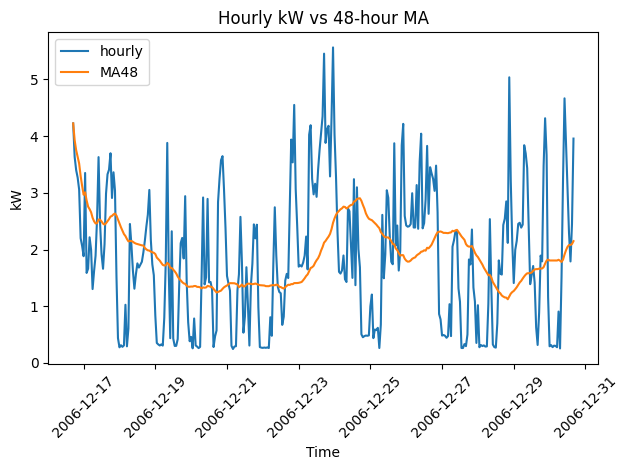

In [11]:
# Compute the 48-hour rolling mean
ma48 = hourly_kw_i.rolling(48, min_periods=1).mean()

# Plot the hourly kW and its 48-hour moving average
plot_two_series(hourly_kw_i.iloc[:24*14], ma48.iloc[:24*14], title="Hourly kW vs 48‑hour MA", ylabel="kW", legend=("hourly","MA48"), rotation=45)

In [12]:
# Compute z-scores based on 48-hour rolling mean/std
roll = hourly_kw_i.rolling(48, min_periods=24)
mu = roll.mean(); sd = roll.std()
z = (hourly_kw_i - mu) / sd
outliers = hourly_kw_i[z.abs() > 3]

print("Hourly outliers (|z|>3):", int(outliers.count()))

outliers.head()

Hourly outliers (|z|>3): 411


timestamp
2006-12-28 21:00:00+01:00    5.035333
2007-01-04 00:00:00+01:00    3.375067
2007-01-07 18:00:00+01:00    5.211533
2007-01-13 22:00:00+01:00    5.814267
2007-01-20 19:00:00+01:00    5.343033
Name: Global_active_power, dtype: float64

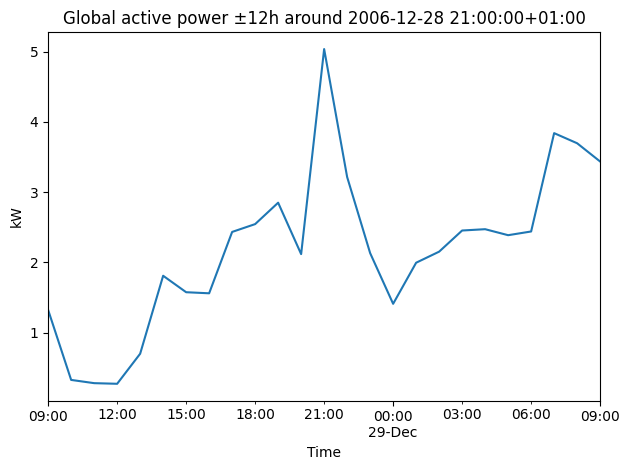

In [13]:
# Inspect one of the outliers and its context
anchor = outliers.index[0]

# Window to inspect
k = 12 # hours before/after
win = slice(anchor - pd.Timedelta(hours=k), anchor + pd.Timedelta(hours=k))

# Plot global active power around the anchor date
ax = hourly_kw_i.loc[win].plot(title=f"Global active power ±{k}h around {anchor}", ylabel="kW", xlabel="Time")
plt.tight_layout()
plt.show()

## 7) Daily aggregates & **energy (kWh)**

**Active power** is in kW. Over one hour, **energy** is approximately `mean(kW) × 1 hour` = **kWh**.
Two equivalent ways to estimate daily `kWh` from minute data:

1) **Hour then sum**: `hourly_kwh = hourly_kw_i * 1.0` and `daily_kwh = hourly_kwh.resample('D').sum()`  
2) **Minute integration**: `minute_kwh = kw/60` then `resample('D').sum()`

We compute both and compare.


,method1_hour_sum,method2_minute_sum
timestamp,,
2006-12-16 00:00:00+01:00,21.842089,20.152933
2006-12-17 00:00:00+01:00,56.507667,56.507667
2006-12-18 00:00:00+01:00,36.730433,36.730433
2006-12-19 00:00:00+01:00,27.769900,27.769900
2006-12-20 00:00:00+01:00,37.095800,37.095800
2006-12-21 00:00:00+01:00,28.628222,28.610400
2006-12-22 00:00:00+01:00,39.022300,39.022300
2006-12-23 00:00:00+01:00,79.556433,79.556433
2006-12-24 00:00:00+01:00,42.500200,42.500200


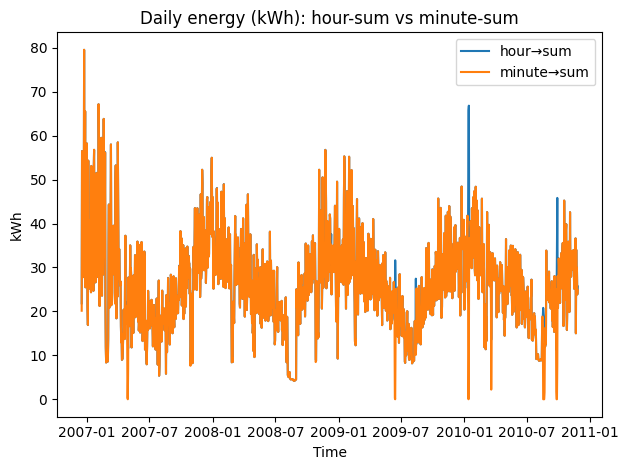

In [14]:
# Method 1: Hour → sum
hourly_kwh = hourly_kw_i * 1.0           # kW * 1 hour = kWh
daily_kwh_1 = hourly_kwh.resample("D").sum()

# Method 2: Minute integration → sum
minute_kwh = kw.fillna(0) / 60.0         # each minute contributes kW * (1/60) hours
daily_kwh_2 = minute_kwh.resample("D").sum()

# Align and compare (they won't be exactly equal due to missing/imputation choices)
aligned = pd.concat([daily_kwh_1.rename("method1_hour_sum"),
                     daily_kwh_2.rename("method2_minute_sum")], axis=1)

display(aligned.head(10))
plot_two_series(aligned["method1_hour_sum"].dropna(), aligned["method2_minute_sum"].dropna(),
                title="Daily energy (kWh): hour-sum vs minute-sum", ylabel="kWh",
                legend=("hour→sum","minute→sum"))

**Question:** Why are these two methods not exactly equal?

## 8) Daily summaries & seasonality hints

We craft daily aggregates (mean/max/min kW, energy kWh) and then do quick calendar summaries by **day of week** and **hour of day** (based on the original minute series).


,daily_kw_mean,daily_kw_max,daily_kw_min,daily_energy_kwh
timestamp,,,,
2006-12-16 00:00:00+01:00,3.053475,7.706,0.284,21.842089
2006-12-17 00:00:00+01:00,2.354486,7.064,0.206,56.507667
2006-12-18 00:00:00+01:00,1.530435,6.158,0.202,36.730433
2006-12-19 00:00:00+01:00,1.157079,7.840,0.194,27.769900
2006-12-20 00:00:00+01:00,1.545658,5.988,0.202,37.095800
2006-12-21 00:00:00+01:00,1.193758,5.854,0.194,28.628222
2006-12-22 00:00:00+01:00,1.625929,7.884,0.202,39.022300
2006-12-23 00:00:00+01:00,3.314851,8.698,0.208,79.556433
2006-12-24 00:00:00+01:00,1.770842,6.824,0.196,42.500200


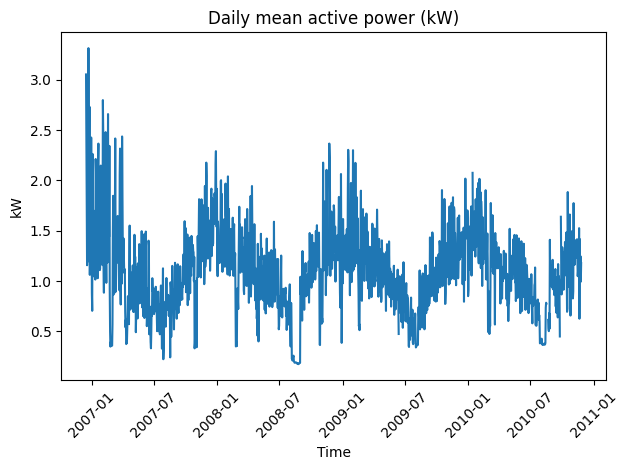

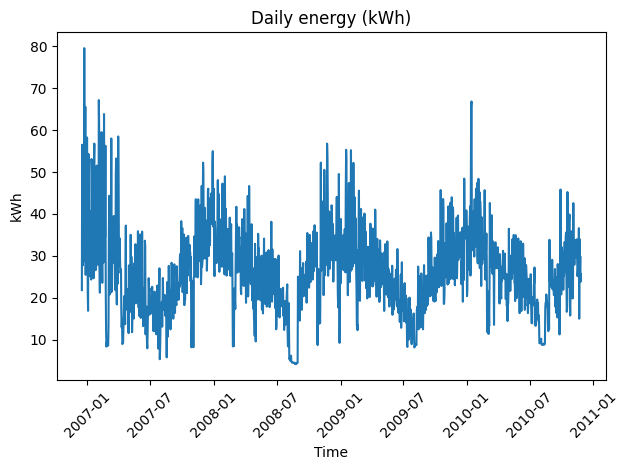

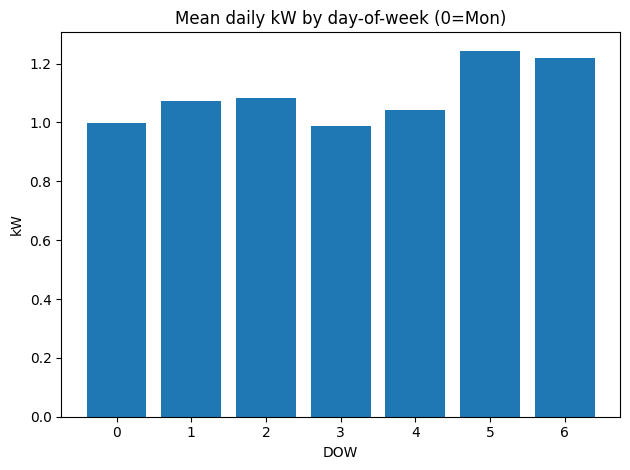

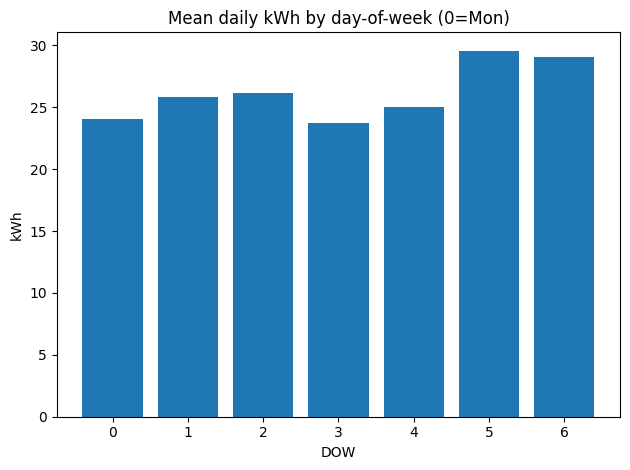

In [15]:
daily_kw_mean = kw.resample("D").mean()
daily_kw_max  = kw.resample("D").max()
daily_kw_min  = kw.resample("D").min()
daily_energy  = daily_kwh_1  # pick method 1 as our canonical energy series

display(pd.concat([daily_kw_mean.rename("daily_kw_mean"),
                   daily_kw_max.rename("daily_kw_max"),
                   daily_kw_min.rename("daily_kw_min"),
                   daily_energy.rename("daily_energy_kwh")], axis=1).head(10))

plot_series(daily_kw_mean, title="Daily mean active power (kW)", ylabel="kW", rotation=45)
plot_series(daily_energy,  title="Daily energy (kWh)", ylabel="kWh", rotation=45)

# Calendar summaries
by_dow_kw = daily_kw_mean.groupby(daily_kw_mean.index.dayofweek).mean()
by_dow_kwh = daily_energy.groupby(daily_energy.index.dayofweek).mean()

fig = plt.figure()
plt.bar(range(7), by_dow_kw.values)
plt.title("Mean daily kW by day-of-week (0=Mon)")
plt.xlabel("DOW"); plt.ylabel("kW"); plt.tight_layout(); plt.show()

fig = plt.figure()
plt.bar(range(7), by_dow_kwh.values)
plt.title("Mean daily kWh by day-of-week (0=Mon)")
plt.xlabel("DOW"); plt.ylabel("kWh"); plt.tight_layout(); plt.show()

## 9) Hour‑of‑day profile (from hourlies)

We compute the **average hour‑of‑day** profile across the dataset, a quick way to see typical daily usage shape.


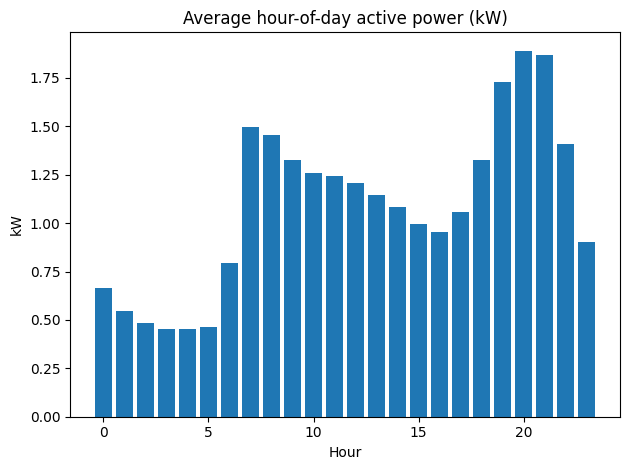

In [16]:
hod = hourly_kw_i.groupby(hourly_kw_i.index.hour).mean()
fig = plt.figure()
plt.bar(range(24), hod.values)
plt.title("Average hour-of-day active power (kW)")
plt.xlabel("Hour"); plt.ylabel("kW"); plt.tight_layout(); plt.show()

---
## Wrap‑up
- Started with **minute-level** power data
- Localized to **Europe/Paris** and exposed DST ambiguities as `NaT`
- Used `asfreq()` to reveal gaps and `resample()` to aggregate
- Imputed small gaps and built rolling smoothers
- Flagged outliers with a rolling z‑score
- Computed **daily energy (kWh)** via two (roughly) equivalent approaches
- Produced quick calendar summaries and saved cleaned series
